# Intraoperative traction influence on patient reported outcomes measures (PROMs) after hip arthroscopy

## Hypothesis

1. Increased **surgical time** will be associated with **decreased likelihood** of achieving the minimal clinically important difference (**MCID**) and/or substantial clinical benefit (**SCB**) after **arthroscopic treatment** of femoroacetabular impingement (**FAI**)
2. Increased **traction time** will be associated with **decreased likelihood** of achieving the **MCID** and/or **SCB** after **arthroscopic treatment** of **FAI**

## Background

- Hip arthroscopy is a viable and successful option in Mx of non-arthritic hip disease
- Hip arthroscopy is demanding (constant traction) and has a high learning curve (requires a large case and regular case load)
- Previous **inverse correlation** between **surgical volume vs. surgical duration + complication rates**
- Little research on hip arthroscopy duration + traction vs PROMs

## Aims

Patient review postoperatively at:

- 6 months
- 12 months
- 24 months

Using four PROMs: 

1. modified Harris Hip Score (mHHS)
2. Hip-Outcome Score - Activities of Daily Living (HOS-ADL)
3. Hip Outcome Score - Sports Specific (HOS-SS)
4. international Hip Outcome Tool (iHOT-33)

### Primary

Illustrate effect of surgical duration on achievement of threshold scores such as MCID ± SCB after arthroscopic treatment of FAI (cam decompression and labral repair)

### Secondary

Effect of traction duration on achievement rates of threshold scores.
> Multivariable analysis controlling for age, sex, baseline PROMs scores and pre-operative diagnosis to determine if surgical duration ± traction duration can be considered independent risk factors (RFs) for achieving, or failure to achieve, threshold scores on PROMs after hip arthroscopy

### Inclusion Criteria

- Ages 18-80
- Primary arthroscopic hip surgery performed at HSS
- Minimum of pre-operative completed questionnaire
- Primary hip arthroscopy consisted of cam decompression and labral repair

### Exclusion Criteria

- Prior history of ipsilateral hip surgery
- Pre-existing congenital hip condition
- High grade osteoarthritis (defined as Tonnis grade > 2)

## Reference values

Prior literature has shown utilization of the following reference values at both 6 and 24 months time points after hip arthroscopy

References values for MCID:

- mHHS = 8.2
- HOS-ADL = 8.3
- HOS-SS = 14.5
- iHOT-33 = 12.1

SCB values will be reported as an absolute score (instead of a change score):
- mHHS = 82.5
- HOS-ADL = 93.3
- HOS-SS = 84.4
- iHOT-33 = 63.5


In [4]:
# stats libs
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pandas_profiling import ProfileReport
from scipy.stats import chi2_contingency, ttest_rel, mannwhitneyu

# graph libs
import seaborn as sns
sns.set_theme()
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from plotnine import *

# ensure reproducibility
np.random.seed(123)

#ignore errors about using jupyter notebook or sample size being too small
import warnings
warnings.simplefilter("ignore", UserWarning) 

In [5]:
df = pd.read_csv('data/traction.csv')
# drop all patient identifiable information
df = df.drop(columns=[
  'PID', 
  'SID', 
  'SMDateofSurgery', 
  'LastName', 
  'FirstName', 
  'DateofBirth'
  ])

In [6]:
df.head()

,side,Sex,age,Procedure,Surgeon,PreDiagRevision,PreDiagLabTear,PreDiagCam,PreDiagPincer,ProcLTDwPres,...,nFU6m,nFU1y,nFU2y,nFU3y,nFU4y,nFU5y,nFU6y,nFU7y,nFU8y,nFU9y
0,LEFT,M,26,Scope,BK,0.0,0.0,0.0,0.0,0.0,...,4,0,4,0,0,0,0,0,0,0
1,RIGHT,F,27,Scope,BK,0.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,RIGHT,M,18,Scope,AR,0.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,RIGHT,M,35,Scope,AR,0.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,RIGHT,M,21,Scope,AR,0.0,1.0,1.0,1.0,0.0,...,0,4,0,0,0,0,0,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3528 entries, 0 to 3527
Data columns (total 82 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   side                            3527 non-null   object 
 1   Sex                             3528 non-null   object 
 2   age                             3528 non-null   int64  
 3   Procedure                       3528 non-null   object 
 4   Surgeon                         3528 non-null   object 
 5   PreDiagRevision                 3008 non-null   float64
 6   PreDiagLabTear                  3007 non-null   float64
 7   PreDiagCam                      3007 non-null   float64
 8   PreDiagPincer                   3007 non-null   float64
 9   ProcLTDwPres                    3008 non-null   float64
 10  ProcLTDwRefix                   3008 non-null   float64
 11  ProcCamDecom                    3008 non-null   float64
 12  ProcRimDecom                    30

In [8]:
# drop the one row where we don't have the side info
df = df.dropna(subset='side')

In [9]:
# drop the rows where we don't have the traction info
df.loc[:, 'GeneralTractionTime':'GeneralSurgeryTime'] = df.loc[:, 'GeneralTractionTime':'GeneralSurgeryTime'].replace(to_replace='x', value=np.nan)
df = df.dropna(subset=['GeneralTractionTime'])
df['GeneralTractionTime'] = df['GeneralTractionTime'].astype(np.int64)
df['GeneralSurgeryTime'] = df['GeneralSurgeryTime'].replace(to_replace='bilateral', value=np.nan).astype(np.float64)

In [10]:
# look into detail on the surgical stats
col_surg_stats = df.loc[:, 'PreDiagRevision':'simultane'].columns
df.loc[:, col_surg_stats].describe()

,PreDiagRevision,PreDiagLabTear,PreDiagCam,PreDiagPincer,ProcLTDwPres,ProcLTDwRefix,ProcCamDecom,ProcRimDecom,NoComplication,ComplicationDamageLab,...,ComplicationInstBreak,ComplicationHeadScuff,ComplicationDifficultTraction,ComplicationIatrogenicCartInj,GeneralTractionTime,GeneralSurgeryTime,GeneralFluidBags,PCVCamLesion,surgery_yr,simultane
count,2673.0,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.0,...,2673.000000,2673.000000,2673.000000,2673.0,3034.000000,3013.000000,2399.000000,2673.0,3034.000000,111.0
mean,0.0,0.980546,0.895623,0.371493,0.131313,0.852974,0.893378,0.368874,0.905350,0.0,...,0.000748,0.003741,0.001871,0.0,45.178642,81.423498,3.865777,0.0,2013.874753,1.0
std,0.0,0.138139,0.305806,0.483294,0.337806,0.354198,0.308690,0.482590,0.292786,0.0,...,0.027349,0.061062,0.043218,0.0,13.545313,28.196190,59.403698,0.0,2.287339,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.0,2009.000000,1.0
25%,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.0,35.000000,70.000000,1.000000,0.0,2012.000000,1.0
50%,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.0,45.000000,77.000000,1.000000,0.0,2014.000000,1.0
75%,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.0,51.000000,90.000000,1.000000,0.0,2016.000000,1.0
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,0.0,150.000000,900.000000,1600.000000,0.0,2018.000000,1.0


**Dropping unclear columns**

- GeneralFluidBags - incomplete dataset, and unclear if necessary for this analysis
- simultane - incomplete dataset only 179 values, therefore dropped as unusable
- drop follow-up > 2 years as to low numbers for analysis
- nFU columns - unclear what these are for, as followup is already documented in scores

In [11]:
df = df.drop(columns=[
  'GeneralFluidBags', 
  'simultane',
  'HHS35to47mScoreLast',
  'HHS47to59mScoreLast',
  'HHS59to71mScoreLast',
  'HHS71to83mScoreLast',
  'HHS83to95mScoreLast',
  'HHS95to107mScoreLast',
  'HHS107to119mScoreLast',
  'HOSADL35to47mScoreLast',
  'HOSADL47to59mScoreLast',
  'HOSADL59to71mScoreLast',
  'HOSADL71to83mScoreLast',
  'HOSADL83to95mScoreLast',
  'HOSADL95to107mScoreLast',
  'HOSADL107to119mScoreLast',
  'HOSSport35to47mScoreLast',
  'HOSSport47to59mScoreLast',
  'HOSSport59to71mScoreLast',
  'HOSSport71to83mScoreLast',
  'HOSSport83to95mScoreLast',
  'HOSSport95to107mScoreLast',
  'HOSSport107to119mScoreLast',
  'QOL35to47mScoreLast',
  'QOL47to59mScoreLast',
  'QOL59to71mScoreLast',
  'QOL71to83mScoreLast',
  'QOL83to95mScoreLast',
  'QOL95to107mScoreLast',
  'QOL107to119mScoreLast',
  'nPre',
  'nFU6m',
  'nFU1y',
  'nFU2y',
  'nFU3y',
  'nFU4y',
  'nFU5y',
  'nFU6y',
  'nFU7y',
  'nFU8y',
  'nFU9y',
])
col_surg_stats = df.loc[:, 'PreDiagRevision':'PCVCamLesion'].columns
col_surg_stats

Index(['PreDiagRevision', 'PreDiagLabTear', 'PreDiagCam', 'PreDiagPincer',
       'ProcLTDwPres', 'ProcLTDwRefix', 'ProcCamDecom', 'ProcRimDecom',
       'NoComplication', 'ComplicationDamageLab',
       'ComplicationFluidExtPeriCavity', 'ComplicationInstBreak',
       'ComplicationHeadScuff', 'ComplicationDifficultTraction',
       'ComplicationIatrogenicCartInj', 'OtherComplication',
       'GeneralTractionTime', 'GeneralSurgeryTime', 'PCVCamLesion'],
      dtype='object')

In [12]:
col_surg_bool = col_surg_stats.copy().drop(['GeneralTractionTime', 'GeneralSurgeryTime', 'OtherComplication'])
col_surg_bool

Index(['PreDiagRevision', 'PreDiagLabTear', 'PreDiagCam', 'PreDiagPincer',
       'ProcLTDwPres', 'ProcLTDwRefix', 'ProcCamDecom', 'ProcRimDecom',
       'NoComplication', 'ComplicationDamageLab',
       'ComplicationFluidExtPeriCavity', 'ComplicationInstBreak',
       'ComplicationHeadScuff', 'ComplicationDifficultTraction',
       'ComplicationIatrogenicCartInj', 'PCVCamLesion'],
      dtype='object')

In [13]:
df.loc[:, col_surg_stats].describe()

,PreDiagRevision,PreDiagLabTear,PreDiagCam,PreDiagPincer,ProcLTDwPres,ProcLTDwRefix,ProcCamDecom,ProcRimDecom,NoComplication,ComplicationDamageLab,ComplicationFluidExtPeriCavity,ComplicationInstBreak,ComplicationHeadScuff,ComplicationDifficultTraction,ComplicationIatrogenicCartInj,GeneralTractionTime,GeneralSurgeryTime,PCVCamLesion
count,2673.0,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.000000,2673.0,2673.000000,2673.000000,2673.000000,2673.000000,2673.0,3034.000000,3013.000000,2673.0
mean,0.0,0.980546,0.895623,0.371493,0.131313,0.852974,0.893378,0.368874,0.905350,0.0,0.001122,0.000748,0.003741,0.001871,0.0,45.178642,81.423498,0.0
std,0.0,0.138139,0.305806,0.483294,0.337806,0.354198,0.308690,0.482590,0.292786,0.0,0.033489,0.027349,0.061062,0.043218,0.0,13.545313,28.196190,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.0
25%,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,35.000000,70.000000,0.0
50%,0.0,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,45.000000,77.000000,0.0
75%,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,51.000000,90.000000,0.0
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,150.000000,900.000000,0.0


**ASSUMPTION**

`null` values are considered a negative value for the column, therefore:

fill ~500 rows that have `null` values with default `0.0`

In [14]:
# no complication = True therefore a different fill
df['NoComplication'] = df['NoComplication'].fillna(1)
df.loc[:, col_surg_bool] = df.loc[:, col_surg_bool].fillna(0)
df.loc[:, col_surg_bool] = df.loc[:, col_surg_bool].astype(np.bool_)

In [15]:
df.loc[:, col_surg_bool].describe()

,PreDiagRevision,PreDiagLabTear,PreDiagCam,PreDiagPincer,ProcLTDwPres,ProcLTDwRefix,ProcCamDecom,ProcRimDecom,NoComplication,ComplicationDamageLab,ComplicationFluidExtPeriCavity,ComplicationInstBreak,ComplicationHeadScuff,ComplicationDifficultTraction,ComplicationIatrogenicCartInj,PCVCamLesion
count,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034,3034
unique,1,2,2,2,2,2,2,2,2,1,2,2,2,2,1,1
top,False,True,True,False,False,True,True,False,True,False,False,False,False,False,False,False
freq,3034,2621,2394,2041,2683,2280,2388,2048,2781,3034,3031,3032,3024,3029,3034,3034


In [16]:
df.loc[:, col_surg_bool].mean()

PreDiagRevision                   0.000000
PreDiagLabTear                    0.863876
PreDiagCam                        0.789057
PreDiagPincer                     0.327291
ProcLTDwPres                      0.115689
ProcLTDwRefix                     0.751483
ProcCamDecom                      0.787080
ProcRimDecom                      0.324984
NoComplication                    0.916612
ComplicationDamageLab             0.000000
ComplicationFluidExtPeriCavity    0.000989
ComplicationInstBreak             0.000659
ComplicationHeadScuff             0.003296
ComplicationDifficultTraction     0.001648
ComplicationIatrogenicCartInj     0.000000
PCVCamLesion                      0.000000
dtype: float64

**Analyzing the surgical details**

- No patients had previous revisions so no need to drop any of them
- Majority of patients had a diagnosis of labral tears 76% ± CAM 69%
- Pincer diagnosis in 28%
- 84% of patients had no complication
- <1% of patients were considered a difficult traction case

In [17]:
col_category = ['side', 'Sex', 'Procedure', 'Surgeon']
for col in col_category:
  df[col] = df[col].astype('category')

In [18]:
df[col_category].describe()

,side,Sex,Procedure,Surgeon
count,3034,3034,3034,3034
unique,2,2,1,4
top,RIGHT,M,Scope,BK
freq,1661,1569,3034,2158


In [19]:
col_demo = df.loc[:, :'Surgeon'].columns + ['surgery_yr']
col_HSS = df.loc[:, 'HHSScoreprept':'HHS23to35mScoreLast'].columns
col_HOSADL = df.loc[:, 'HOSADLScoreprept':'HOSADL23to35mScoreLast'].columns
col_HOSSS = df.loc[:, 'HOSSportScoreprept':'HOSSport23to35mScoreLast'].columns
col_QOL = df.loc[:, 'QOLScoreprept':'QOL23to35mScoreLast'].columns

### Inclusion Criteria

- Ages 18-80
- Primary arthroscopic hip surgery performed at HSS
- Minimum of pre-operative completed questionnaire
- Primary hip arthroscopy consisted of cam decompression and labral repair

In [20]:
df_inc = df.copy()
df_inc['age'].count()

3034

In [21]:
# Ages 18-80
df_inc = df_inc[(df_inc['age'] > 18) & (df_inc['age'] < 80)]
df_inc['age'].count()

2885

In [22]:
# Primary arthroscopic hip surgery
df_inc = df_inc[df_inc['Procedure'] == 'Scope']
df_inc['age'].count()

2885

In [23]:
# Minimum of pre-operative completed questionnaire
col_preop_score = ['HHSScoreprept', 'HOSADLScoreprept', 'HOSSportScoreprept', 'QOLScoreprept']
df_inc = df_inc.dropna(subset=col_preop_score)
df_inc['age'].count()

2472

In [24]:
# Primary hip arthroscopy consisted of cam decompression and labral repair
df_inc = df_inc[(df_inc['PreDiagLabTear'] == True) & (df_inc['ProcCamDecom'] == True)]
df_inc['age'].count()

1886

### Exclusion Criteria

- Prior history of ipsilateral hip surgery
- Pre-existing congenital hip condition
- High grade osteoarthritis (defined as Tonnis grade > 2)

Already factored in with the original dataset harvest

In [25]:
df_inc["GeneralTractionTime"].describe()

count    1886.000000
mean       45.315483
std        13.530147
min        15.000000
25%        35.000000
50%        45.000000
75%        51.000000
max       120.000000
Name: GeneralTractionTime, dtype: float64

In [26]:
def traction_breakdown(df):
  print('Traction breakdown:')
  for x in range(40, 91, 5):
    count = df[df['GeneralTractionTime'] >= x]['age'].count()
    print("≥{}min: {} pts".format(x, count))

traction_breakdown(df_inc)

Traction breakdown:
≥40min: 1199 pts
≥45min: 953 pts
≥50min: 539 pts
≥55min: 422 pts
≥60min: 346 pts
≥65min: 162 pts
≥70min: 120 pts
≥75min: 76 pts
≥80min: 58 pts
≥85min: 42 pts
≥90min: 37 pts


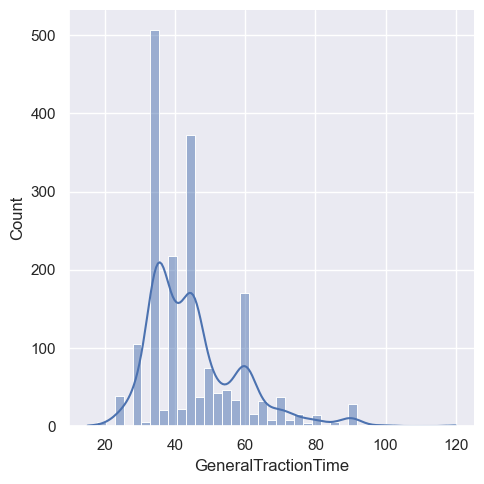

In [27]:
sns.displot(data=df_inc, x="GeneralTractionTime", kde=True)

### Expanding exclusion criteria to expand follow-up %

Primary reason for data issues are loss of patients due to follow-up. So we must exclude patients that did not complete follow-up questionnaires.

In [28]:
df_inc2 = df_inc.copy()

In [29]:
col_postop_6mo_scores = [
  'HHS5to11mScoreLast',
  'HOSADL5to11mScoreLast',
  'HOSSport5to11mScoreLast',
  'QOL5to11mScoreLast',
]
df_inc2 = df_inc2.dropna(subset=col_postop_6mo_scores)
df_inc2['age'].count()


892

In [30]:
traction_breakdown(df_inc2)

Traction breakdown:
≥40min: 528 pts
≥45min: 401 pts
≥50min: 204 pts
≥55min: 149 pts
≥60min: 118 pts
≥65min: 42 pts
≥70min: 34 pts
≥75min: 21 pts
≥80min: 16 pts
≥85min: 14 pts
≥90min: 12 pts


In [31]:
df_inc2.describe()

,age,GeneralTractionTime,GeneralSurgeryTime,surgery_yr,HHSScoreprept,HHS5to11mScoreLast,HHS11to23mScoreLast,HHS23to35mScoreLast,HOSADLScoreprept,HOSADL5to11mScoreLast,HOSADL11to23mScoreLast,HOSADL23to35mScoreLast,HOSSportScoreprept,HOSSport5to11mScoreLast,HOSSport11to23mScoreLast,HOSSport23to35mScoreLast,QOLScoreprept,QOL5to11mScoreLast,QOL11to23mScoreLast,QOL23to35mScoreLast
count,892.000000,892.000000,887.000000,892.000000,892.000000,892.00000,538.000000,288.000000,892.000000,892.000000,539.00000,291.000000,892.000000,892.000000,530.000000,287.000000,892.000000,892.000000,511.000000,258.000000
mean,31.315022,43.193946,84.216460,2013.607623,62.724664,80.51704,83.088848,84.852778,74.049204,88.467007,90.52256,90.857010,52.310101,71.431278,78.394717,80.752474,40.853285,69.673430,74.293249,76.315078
std,9.373200,11.940718,21.723962,2.004111,12.992900,15.20553,15.102732,15.140533,16.223875,13.168883,12.83055,13.971218,24.193286,26.171789,24.965618,24.497779,17.668529,22.163877,22.516550,23.760687
min,19.000000,15.000000,8.000000,2010.000000,12.100000,14.30000,26.400000,40.700000,8.820000,14.580000,15.62000,27.940000,0.000000,0.000000,0.000000,0.000000,0.480000,0.430000,2.030000,1.930000
25%,23.000000,35.000000,70.000000,2012.000000,53.900000,70.40000,71.500000,73.700000,64.547500,84.732500,87.50000,88.240000,36.110000,55.560000,65.882500,72.220000,28.447500,54.320000,59.705000,63.465000
50%,30.000000,40.000000,80.000000,2013.000000,64.900000,84.70000,84.700000,89.650000,76.470000,92.650000,95.59000,97.060000,52.780000,77.780000,88.890000,91.670000,40.375000,74.105000,80.650000,84.760000
75%,38.000000,45.000000,90.000000,2015.000000,70.400000,95.70000,95.700000,95.700000,86.760000,98.357500,98.53000,100.000000,69.440000,92.860000,100.000000,100.000000,53.065000,88.917500,93.700000,95.460000
max,58.000000,100.000000,190.000000,2018.000000,100.100000,100.10000,100.100000,100.100000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,96.190000,100.000000,100.000000,100.000000


In [32]:
col_postop_1yr_scores = [
  'HHS11to23mScoreLast',
  'HOSADL11to23mScoreLast',
  'HOSSport11to23mScoreLast',
  'QOL11to23mScoreLast',
]
df_inc3 = df_inc2.dropna(subset=col_postop_1yr_scores)
df_inc3['age'].count()

505

In [33]:
col_postop_2yr_scores = [
  'HHS23to35mScoreLast',
  'HOSADL23to35mScoreLast',
  'HOSSport23to35mScoreLast',
  'QOL23to35mScoreLast',
]

In [34]:
df_inc3_2yr_na = df_inc3[
  (df_inc2['HHS23to35mScoreLast'].isna()) |
  (df_inc2['HOSADL23to35mScoreLast'].isna()) |
  (df_inc2['HOSSport23to35mScoreLast'].isna()) |
  (df_inc2['QOL23to35mScoreLast'].isna())
]
df_inc3_2yr_na['age'].count()

327

### Adjusting data for >80% followup at 2 years

**100% follow up at 1 year** has been applied to the data with **505 patients left**
If we are to apply 100% follow up at 2 years we will need to drop 327 patients (64% of our dataset). We can do better than this by checking the traction breakdown and dropping the patients that had fast traction times (less important data) and ensuring **>80% follow up at 2 years**.

In [35]:
traction_breakdown(df_inc3_2yr_na)

Traction breakdown:
≥40min: 170 pts
≥45min: 119 pts
≥50min: 55 pts
≥55min: 39 pts
≥60min: 30 pts
≥65min: 9 pts
≥70min: 6 pts
≥75min: 4 pts
≥80min: 3 pts
≥85min: 3 pts
≥90min: 3 pts


In [36]:
df_inc3[
  ((df_inc3['HHS23to35mScoreLast'].isna()) |
  (df_inc3['HOSADL23to35mScoreLast'].isna()) |
  (df_inc3['HOSSport23to35mScoreLast'].isna()) |
  (df_inc3['QOL23to35mScoreLast'].isna())) &
  (df_inc3['GeneralTractionTime'] < 60)
]['age'].count()

297

In [37]:
print("297/372 = {0:.2f}% follow-up at 2 years".format(297/327*100))

297/372 = 90.83% follow-up at 2 years


In [38]:
df_inc4 = df_inc3.drop(index=df_inc3[
  ((df_inc3['HHS23to35mScoreLast'].isna()) |
  (df_inc3['HOSADL23to35mScoreLast'].isna()) |
  (df_inc3['HOSSport23to35mScoreLast'].isna()) |
  (df_inc3['QOL23to35mScoreLast'].isna())) &
  (df_inc3['GeneralTractionTime'] < 50)
].index)
df_inc4['age'].count()

233

In [39]:
df_inc4.describe()

,age,GeneralTractionTime,GeneralSurgeryTime,surgery_yr,HHSScoreprept,HHS5to11mScoreLast,HHS11to23mScoreLast,HHS23to35mScoreLast,HOSADLScoreprept,HOSADL5to11mScoreLast,HOSADL11to23mScoreLast,HOSADL23to35mScoreLast,HOSSportScoreprept,HOSSport5to11mScoreLast,HOSSport11to23mScoreLast,HOSSport23to35mScoreLast,QOLScoreprept,QOL5to11mScoreLast,QOL11to23mScoreLast,QOL23to35mScoreLast
count,233.000000,233.000000,230.000000,233.000000,233.000000,233.000000,233.000000,179.000000,233.000000,233.000000,233.000000,180.000000,233.000000,233.000000,233.000000,180.000000,233.000000,233.000000,233.000000,178.000000
mean,32.381974,46.270386,90.591304,2013.527897,61.741631,82.353648,85.021030,85.677095,73.474077,89.876137,91.767124,91.806278,50.710558,72.141459,81.339099,82.789833,39.212961,72.542961,77.231631,78.313146
std,9.492512,12.595834,22.214278,1.873210,12.578499,13.069136,14.425308,14.860357,16.145890,11.277057,12.647950,13.275915,23.863717,24.729003,22.492374,23.375115,17.196654,19.760295,20.792020,22.749702
min,19.000000,20.000000,20.000000,2010.000000,24.200000,38.500000,26.400000,41.800000,23.530000,23.210000,15.620000,27.940000,0.000000,0.000000,0.000000,0.000000,3.560000,15.220000,2.030000,10.110000
25%,25.000000,35.000000,70.000000,2012.000000,53.900000,73.700000,78.100000,81.400000,63.240000,86.760000,88.240000,89.710000,33.330000,59.380000,69.440000,75.000000,27.290000,60.260000,67.230000,68.032500
50%,32.000000,45.000000,90.000000,2013.000000,64.900000,84.700000,92.400000,95.700000,76.470000,94.120000,97.060000,97.060000,50.000000,79.170000,90.620000,93.305000,38.900000,76.550000,81.680000,87.840000
75%,39.000000,55.000000,101.500000,2015.000000,70.400000,95.700000,95.700000,95.700000,86.760000,97.060000,100.000000,100.000000,69.440000,91.670000,100.000000,100.000000,51.940000,89.660000,94.130000,95.520000
max,56.000000,91.000000,180.000000,2017.000000,95.700000,100.100000,100.100000,100.100000,98.530000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,90.130000,99.810000,100.000000,100.000000


We have dropped 272 patients with no follow up in 2 years and traction times <50 mins. This leaves us with a **cohort of 233 patients** and a follow up of `233/327 ~ 71.3%` at 2 years

In [40]:
df_inc4["GeneralTractionTime"].describe()

count    233.000000
mean      46.270386
std       12.595834
min       20.000000
25%       35.000000
50%       45.000000
75%       55.000000
max       91.000000
Name: GeneralTractionTime, dtype: float64

In [41]:
traction_breakdown(df_inc4)

Traction breakdown:
≥40min: 161 pts
≥45min: 140 pts
≥50min: 88 pts
≥55min: 61 pts
≥60min: 48 pts
≥65min: 13 pts
≥70min: 9 pts
≥75min: 6 pts
≥80min: 5 pts
≥85min: 4 pts
≥90min: 4 pts


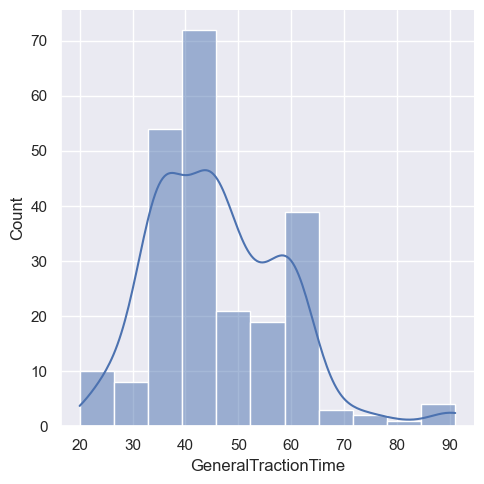

In [42]:
sns.displot(data=df_inc4, x="GeneralTractionTime", kde=True)

In [43]:
profile = ProfileReport(df_inc4, title="Profile Report", minimal=True)
profile.to_file("pandas_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
# final dataframe
dff = df_inc4.copy()

In [45]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 13 to 3404
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   side                            233 non-null    category
 1   Sex                             233 non-null    category
 2   age                             233 non-null    int64   
 3   Procedure                       233 non-null    category
 4   Surgeon                         233 non-null    category
 5   PreDiagRevision                 233 non-null    bool    
 6   PreDiagLabTear                  233 non-null    bool    
 7   PreDiagCam                      233 non-null    bool    
 8   PreDiagPincer                   233 non-null    bool    
 9   ProcLTDwPres                    233 non-null    bool    
 10  ProcLTDwRefix                   233 non-null    bool    
 11  ProcCamDecom                    233 non-null    bool    
 12  ProcRimDecom        

In [46]:
# 2 cohorts, based on traction time > 60 > mins
df_fast = dff[dff['GeneralTractionTime'] < 60]
df_slow = dff[~dff.index.isin(df_fast.index)]
print("pts <60 min traction: {}".format(df_fast['age'].count()))
print("pts >60 min traction: {}".format(df_slow['age'].count()))

pts <60 min traction: 185
pts >60 min traction: 48


In [47]:
dff['age'].count() - dff[dff['Sex'] == 'F']['Sex'].count()

113

In [53]:
col_table1 = [
  'n', 
  'Traction Time', 
  'Surgical Time', 
  'Age', 
  'Female', 
  'Male', 
  'Labral Tear',
  'Cam Lesion', 
  'Pincer Lesion',
  'Labral Repair',
  'Labral Debridement',
  'Cam Decompression',
  'Pincer Resection'
]

def cohort_demo(*dfs):
  cohort_series = []
  for df in dfs:
    female_count = df[df['Sex'] == 'F']['Sex'].count()
    demo_series = [
      df['age'].count(),
      "{0:.1f} ± {1:.1f}".format(df['GeneralTractionTime'].mean(), df['GeneralTractionTime'].std()),
      "{0:.1f} ± {1:.1f}".format(df['GeneralSurgeryTime'].mean(), df['GeneralSurgeryTime'].std()),
      "{0:.1f} ± {1:.1f}".format(df['age'].mean(), df['age'].std()),
      "{0} ({1:.1f}%)".format(female_count, female_count/df['age'].count() * 100),
      "{0} ({1:.1f}%)".format(df['age'].count() - female_count, (1-female_count/df['age'].count()) * 100),
      "{0} ({1:.1f}%)".format(df['PreDiagLabTear'].sum(), df['PreDiagLabTear'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['PreDiagCam'].sum(), df['PreDiagCam'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['PreDiagPincer'].sum(), df['PreDiagPincer'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['ProcLTDwRefix'].sum(), df['ProcLTDwRefix'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['ProcLTDwPres'].sum(), df['ProcLTDwPres'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['ProcCamDecom'].sum(), df['ProcCamDecom'].mean() * 100),
      "{0} ({1:.1f}%)".format(df['ProcRimDecom'].sum(), df['ProcRimDecom'].mean() * 100),
    ]   
    cohort_series.append(demo_series)
  return pd.DataFrame(cohort_series, index=['Total', 'Cohort 1', 'Cohort 2'], columns=col_table1).T

fig1 = cohort_demo(dff, df_fast, df_slow)

col_table1_raw = [
  'GeneralSurgeryTime',
  'age',
  'Sex',
  'Sex',
  'PreDiagLabTear',
  'PreDiagCam',
  'PreDiagPincer',
  'ProcLTDwRefix',
  'ProcLTDwPres',
  'ProcCamDecom',
  'ProcRimDecom'
]

cohort_bool = dff['GeneralTractionTime'] < 60
p_vals = ['-', '-']

for col in col_table1_raw:
  chisqt = pd.crosstab(cohort_bool, dff[col])
  value = np.array([chisqt.iloc[0].values, chisqt.iloc[1].values])
  p = chi2_contingency(value)[1]
  if p < 0.05:
    p = "<0.05"
  else:
    p = "{:.3f}".format(p)
  p_vals.append(p)

fig1['P Values'] = p_vals
fig1

,Total,Cohort 1,Cohort 2,P Values
n,233,185,48,-
Traction Time,46.3 ± 12.6,41.5 ± 8.3,64.7 ± 9.0,-
Surgical Time,90.6 ± 22.2,84.1 ± 17.9,116.0 ± 19.1,<0.05
Age,32.4 ± 9.5,32.5 ± 9.1,31.8 ± 11.1,0.147
Female,120 (51.5%),101 (54.6%),19 (39.6%),0.091
Male,113 (48.5%),84 (45.4%),29 (60.4%),0.091
Labral Tear,233 (100.0%),185 (100.0%),48 (100.0%),1.000
Cam Lesion,233 (100.0%),185 (100.0%),48 (100.0%),1.000
Pincer Lesion,63 (27.0%),38 (20.5%),25 (52.1%),<0.05
Labral Repair,193 (82.8%),152 (82.2%),41 (85.4%),0.750


In [54]:
timelines_prom = [
  'Baseline',
  '6 Months Postop',
  '1 Year Postop',
  '2 Years Postop'
]
score_types = [
  'mHHS',
  'HOS-ADL',
  'HOS-SS',
  'iHOT'
]

scores_index_prom = pd.MultiIndex.from_product([timelines_prom, score_types], names=['Timeline', 'Score Type'])

col_scores = {
  "HSS": [
    'HHSScoreprept',
    'HHS5to11mScoreLast',
    'HHS11to23mScoreLast',
    'HHS23to35mScoreLast'
  ],
  "HOSADL": [
    'HOSADLScoreprept',
    'HOSADL5to11mScoreLast',
    'HOSADL11to23mScoreLast',
    'HOSADL23to35mScoreLast'
  ],
  "HOSSS": [
    'HOSSportScoreprept',
    'HOSSport5to11mScoreLast',
    'HOSSport11to23mScoreLast',
    'HOSSport23to35mScoreLast'
  ],
  "HOT": [
    'QOLScoreprept',
    'QOL5to11mScoreLast',
    'QOL11to23mScoreLast',
    'QOL23to35mScoreLast'
  ]
}

def cohort_scores(*dfs):
  score_data = []
  for df in dfs:
    score_series = []
    for i in range(len(col_scores.keys())):
      score_series += [
        "{0:.1f} ± {1:.1f}".format(df[col_scores["HSS"][i]].mean(), df[col_scores["HSS"][i]].std()),
        "{0:.1f} ± {1:.1f}".format(df[col_scores["HOSADL"][i]].mean(), df[col_scores["HOSADL"][i]].std()),
        "{0:.1f} ± {1:.1f}".format(df[col_scores["HOSSS"][i]].mean(), df[col_scores["HOSSS"][i]].std()),
        "{0:.1f} ± {1:.1f}".format(df[col_scores["HOT"][i]].mean(), df[col_scores["HOT"][i]].std()),
      ]
    score_data.append(pd.Series(score_series, index=scores_index_prom))

  p_vals = []
  for i in range(len(col_scores.keys())):
    p_vals += [
      mannwhitneyu(dfs[0][col_scores["HSS"][i]].dropna(), dfs[1][col_scores["HSS"][i]].dropna()),
      mannwhitneyu(dfs[0][col_scores["HOSADL"][i]].dropna(), dfs[1][col_scores["HOSADL"][i]].dropna()),
      mannwhitneyu(dfs[0][col_scores["HOSSS"][i]].dropna(), dfs[1][col_scores["HOSSS"][i]].dropna()),
      mannwhitneyu(dfs[0][col_scores["HOT"][i]].dropna(), dfs[1][col_scores["HOT"][i]].dropna()),
    ]
  p_vals = ["<0.05" if x[1] < 0.05 else "{:.3f}".format(x[1]) for x in p_vals]
  score_data.append(pd.Series(p_vals, index=scores_index_prom))

  return pd.concat(score_data, axis=1)

fig2 = cohort_scores(df_fast, df_slow)
fig2.columns = ['Cohort 1', 'Cohort 2', 'P Values']
fig2

Cohort 1     Cohort 2 P Values
Timeline        Score Type                                   
Baseline        mHHS        61.3 ± 12.7  63.5 ± 12.2    0.245
                HOS-ADL     73.0 ± 16.8  75.5 ± 13.1    0.605
                HOS-SS      49.9 ± 24.2  53.9 ± 22.6    0.270
                iHOT        38.8 ± 17.6  40.9 ± 15.6    0.605
6 Months Postop mHHS        82.2 ± 13.5  82.8 ± 11.3    0.812
                HOS-ADL     90.1 ± 11.6  88.9 ± 10.0    0.120
                HOS-SS      72.7 ± 24.9  69.8 ± 24.2    0.309
                iHOT        72.4 ± 20.3  73.0 ± 17.6    0.827
1 Year Postop   mHHS        85.5 ± 14.6  83.3 ± 13.7    0.242
                HOS-ADL     91.6 ± 13.4   92.4 ± 9.1    0.441
                HOS-SS      81.9 ± 23.0  79.3 ± 20.4    0.098
                iHOT        77.5 ± 21.3  76.1 ± 19.0    0.334
2 Years Postop  mHHS        85.4 ± 15.2  88.1 ± 11.2    0.689
                HOS-ADL     91.5 ± 13.9   94.4 ± 5.7    0.806
                HOS-SS      82.6 ± 24.2  84.5 ± 14.9    0.636
                iHOT        77.9 ± 23.4  82.2 ± 15.9    0.774

In [55]:
timelines_mcid = [
  'Baseline',
  '6 Months Postop',
  '1 Year Postop',
  '2 Years Postop'
]
score_types = [
  'mHHS',
  'HOS-ADL',
  'HOS-SS',
  'iHOT'
]

scores_index_mcid = pd.MultiIndex.from_product([timelines_mcid[1:], score_types], names=['Timeline', 'Score Type'])

col_scores = {
  "HSS": [
    'HHSScoreprept',
    'HHS5to11mScoreLast',
    'HHS11to23mScoreLast',
    'HHS23to35mScoreLast'
  ],
  "HOSADL": [
    'HOSADLScoreprept',
    'HOSADL5to11mScoreLast',
    'HOSADL11to23mScoreLast',
    'HOSADL23to35mScoreLast'
  ],
  "HOSSS": [
    'HOSSportScoreprept',
    'HOSSport5to11mScoreLast',
    'HOSSport11to23mScoreLast',
    'HOSSport23to35mScoreLast'
  ],
  "HOT": [
    'QOLScoreprept',
    'QOL5to11mScoreLast',
    'QOL11to23mScoreLast',
    'QOL23to35mScoreLast'
  ]
}

mcid_ref = {
  "HSS": 8.2,
  "HOSADL": 8.3,
  "HOSSS": 14.5,
  "HOT": 12.1
}

def cohort_mcid(*dfs):
  dfs_delta = []
  for df_i in range(len(dfs)):
    dfs_delta.append([])
    for t_i in range(1, len(col_scores.keys())):
      dfs_delta[df_i].append({
        "HSS": dfs[df_i][col_scores["HSS"][t_i]] - dfs[df_i][col_scores["HSS"][0]],
        "HOSADL": dfs[df_i][col_scores["HOSADL"][t_i]] - dfs[df_i][col_scores["HOSADL"][0]],
        "HOSSS": dfs[df_i][col_scores["HOSSS"][t_i]] - dfs[df_i][col_scores["HOSSS"][0]],
        "HOT": dfs[df_i][col_scores["HOT"][t_i]] - dfs[df_i][col_scores["HOT"][0]],
      })
  
  table_data = []
  for df_delta in dfs_delta:
    mcid_series = []
    for t_delta in df_delta:
      mcid_series += [
        "{0:.1f}%".format(t_delta["HSS"].mean() / mcid_ref['HSS'] * 100),
        "{0:.1f}%".format(t_delta["HOSADL"].mean() / mcid_ref['HOSADL'] * 100),
        "{0:.1f}%".format(t_delta["HOSSS"].mean() / mcid_ref['HOSSS'] * 100),
        "{0:.1f}%".format(t_delta["HOT"].mean() / mcid_ref['HOT'] * 100),
      ]
    table_data.append(pd.Series(mcid_series, index=scores_index_mcid))

  p_series = []
  for t_i in range(len(col_scores.keys()) - 1):
    p_series += [
      mannwhitneyu(dfs_delta[0][t_i]["HSS"].dropna(), dfs_delta[1][t_i]["HSS"].dropna()),
      mannwhitneyu(dfs_delta[0][t_i]["HOSADL"].dropna(), dfs_delta[1][t_i]["HOSADL"].dropna()),
      mannwhitneyu(dfs_delta[0][t_i]["HOSSS"].dropna(), dfs_delta[1][t_i]["HOSSS"].dropna()),
      mannwhitneyu(dfs_delta[0][t_i]["HOT"].dropna(), dfs_delta[1][t_i]["HOT"].dropna()),
    ]
  p_series = ["<0.05" if x[1] < 0.05 else "{:.3f}".format(x[1]) for x in p_series]
  table_data.append(pd.Series(p_series, index=scores_index_mcid))

  return pd.concat(table_data, axis=1)

df_scores = cohort_mcid(df_fast, df_slow)
df_scores.columns = ['Cohort 1', 'Cohort 2', 'P Values']
df_scores

Cohort 1 Cohort 2 P Values
Timeline        Score Type                           
6 Months Postop mHHS         255.5%   235.3%    0.334
                HOS-ADL      206.8%   162.1%    0.198
                HOS-SS       157.8%   109.4%    0.086
                iHOT         278.1%   265.2%    0.763
1 Year Postop   mHHS         294.8%   241.7%    0.075
                HOS-ADL      224.7%   203.7%    0.692
                HOS-SS       220.6%   175.1%    0.095
                iHOT         320.3%   290.6%    0.293
2 Years Postop  mHHS         295.7%   326.4%    0.752
                HOS-ADL      228.7%   248.1%    0.492
                HOS-SS       223.9%   210.8%    0.769
                iHOT         327.4%   314.9%    0.597

### Multivariable analysis via Logistical Regression

Matched and unmatched based upon controlling for:

- age
- gender
- baseline PROM score
- preoperative diagnosis
- intraoperative procedures

### Design matrices (endog & exog)
To fit most of the models covered by `statsmodels`, you will need to create two design matrices. The first is a matrix of **endogenous variables** (i.e. dependent, response, regressand, etc.). The second is a matrix of **exogenous variables** (i.e. independent, predictor, regressor, etc.).

In [47]:
import statsmodels.api as sm
from patsy import dmatrices

y, X = dmatrices("""HHS5to11mScoreLast ~ 
                  age +
                  Sex +
                  HHSScoreprept +
                  HOSADLScoreprept +
                  HOSSportScoreprept +
                  QOLScoreprept +
                  PreDiagRevision + 
                  PreDiagLabTear + 
                  PreDiagCam +
                  PreDiagPincer +
                  ProcLTDwPres +
                  ProcLTDwRefix +
                  ProcCamDecom +
                  ProcRimDecom +
                  PCVCamLesion
                  """, data=dff, return_type='dataframe')
display(y.head())
display(X.head())

,HHS5to11mScoreLast
10,95.7
11,100.1
13,84.7
14,70.4
21,100.1


,Intercept,Sex[T.M],PreDiagRevision[T.True],PreDiagLabTear[T.True],PreDiagCam[T.True],PreDiagPincer[T.True],ProcLTDwPres[T.True],ProcLTDwRefix[T.True],ProcCamDecom[T.True],ProcRimDecom[T.True],PCVCamLesion[T.True],age,HHSScoreprept,HOSADLScoreprept,HOSSportScoreprept,QOLScoreprept
10,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,41.0,68.2,85.29,86.11,54.50
11,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,32.0,62.7,69.12,44.44,34.84
13,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,33.0,70.4,69.12,67.86,48.17
14,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,25.0,84.7,92.65,86.11,68.10
21,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,31.0,56.1,86.76,66.67,65.90


In [48]:
mod = sm.OLS(y, X) # describe the model
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     HHS5to11mScoreLast   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     9.367
Date:                Sun, 28 Aug 2022   Prob (F-statistic):           1.16e-15
Time:                        13:54:01   Log-Likelihood:                -2499.6
No. Observations:                 621   AIC:                             5023.
Df Residuals:                     609   BIC:                             5076.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  21.7758      4.776      4.559      0.000      12.397      31.155
Sex[T.M]                    2.1022      1.162      1.810      0.071      -0.179       4.384
PreDiagRevision[T.True]  7.067e-13   1.97e-13      3.582      0.000    3.19e-13    1.09e-12
PreDiagLabTear[T.True]     21.7758      4.776      4.559      0.000      12.397      31.155
PreDiagCam[T.True]         -5.7443      9.709     -0.592      0.554     -24.812      13.324
PreDiagPincer[T.True]      -6.1577      2.744     -2.244      0.025     -11.548      -0.768
ProcLTDwPres[T.True]        7.2347      9.860      0.734      0.463     -12.129      26.599
ProcLTDwRefix[T.True]       7.5879      9.748      0.778      0.437     -11.557      26.732
ProcCamDecom[T.True]       21.7758      4.776      4.559      0.000      12.397      31.155
ProcRimDecom[T.True]        4.7720      2.750      1.735      0.083      -0.630      10.173
PCVCamLesion[T.True]    -4.436e-16   2.47e-15     -0.180      0.858    -5.3e-15    4.41e-15
age                        -0.1777      0.059     -3.030      0.003      -0.293      -0.063
HHSScoreprept               0.2561      0.068      3.772      0.000       0.123       0.389
HOSADLScoreprept           -0.0248      0.068     -0.363      0.716      -0.159       0.109
HOSSportScoreprept          0.0229      0.036      0.637      0.524      -0.048       0.094
QOLScoreprept               0.0959      0.055      1.750      0.081      -0.012       0.204
==============================================================================
Omnibus:                       34.241   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.641
Skew:                          -0.607   Prob(JB):                     4.07e-09
Kurtosis:                       3.135   Cond. No.                     3.72e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.95e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""